<a href="https://colab.research.google.com/github/s1c5000/kaggle/blob/main/pima-indians-diabetes/11_%EA%B2%B0%EC%B8%A1%EC%B9%98%EC%98%88%EC%B8%A1_RandomSearchCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 적절한 EDA로 결측치를 예측할 모델데이터를 만든다


## 데이터 load

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d uciml/pima-indians-diabetes-database

  0% 0.00/8.91k [00:00<?, ?B/s]
100% 8.91k/8.91k [00:00<00:00, 7.76MB/s]


In [ ]:
!unzip '/content/pima-indians-diabetes-database.zip'

Archive:  /content/pima-indians-diabetes-database.zip
  inflating: diabetes.csv            


In [ ]:
df = pd.read_csv('/content/diabetes.csv')

In [ ]:
train = df[df['Insulin']>0].copy()
train.shape

(394, 9)

In [ ]:
test = df[df['Insulin']==0].copy()
test.shape

(374, 9)

## 결측치예측의 EDA

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


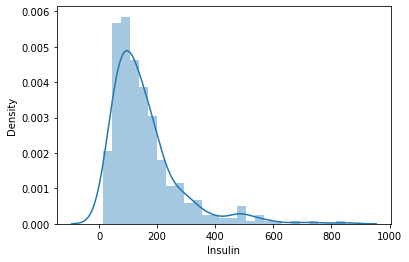

In [ ]:
sns.distplot(train['Insulin']) # Insulin의 분포 뒤에 이상치들이 보인다

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


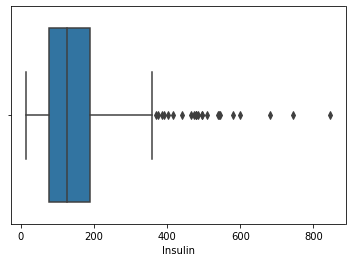

In [ ]:
# 이상치를 보는것은 boxplot이 좋다, 제일 왼쪽과 오른쪽의 선은 min, max값이고 상자는 25%값 50%값 75%값이다
sns.boxplot(train["Insulin"])

In [ ]:
desc = train['Insulin'].describe()
desc

count    394.000000
mean     155.548223
std      118.775855
min       14.000000
25%       76.250000
50%      125.000000
75%      190.000000
max      846.000000
Name: Insulin, dtype: float64

In [ ]:
# IQR 값은 3IQR - 1IQR이고, 이상치는 3IQR + IQR * 1.5
IQR = desc.loc["75%"] - desc.loc["25%"]
OUT = desc.loc["75%"] + (IQR * 1.5)

In [ ]:
train[train['Insulin'] > OUT].shape # 이상치값이 24개 있다

(24, 9)

In [ ]:
# 24개의 값을 이상치로보고 전부 빼도 되지만 
# 그러면 학습데이터가 너무 줄기에 600 이상인 값을 빼주기로했다

print(train.shape)
train = train[train['Insulin'] < OUT]
train.shape

(394, 9)


(370, 9)

## 데이터분할

In [ ]:
feature_names = df.columns.tolist()

In [ ]:
feature_names.remove('Insulin')
feature_names

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

In [ ]:
label_name = 'Insulin'
label_name

'Insulin'

In [ ]:
X_train = train[feature_names]
X_train.shape

(370, 8)

In [ ]:
y_train = train[label_name]
y_train.shape

(370,)

In [ ]:
X_test = test[feature_names]
y_test = test[label_name] # 딱히 안구해도 됌, 예측 할 것이여서
X_test.shape, y_test.shape

((374, 8), (374,))

## 결측치 예측에 사용할 회귀모델 가져오기

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


estimators = [DecisionTreeRegressor(random_state=42),
              RandomForestRegressor(random_state=42),
              GradientBoostingRegressor(random_state=42)
]

estimators

[DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best'),
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False),
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
            

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

results = []
for estimator in estimators:
  result=[]
  max_depth = np.random.randint(5,30,10)
  max_features = np.random.uniform(0.3,1.0,10)

  param_distributions = {
      'max_depth': max_depth,
      'max_features' : max_features
  }
  regressor = RandomizedSearchCV(estimator=estimator,
                     param_distributions=param_distributions,
                     n_iter = 10,
                     n_jobs=-1,
                     cv = 5,
                     random_state=42)
  regressor.fit(X_train, y_train)
  
  result.append(estimator.__class__.__name__)
  result.append(regressor.best_params_)
  result.append(regressor.best_estimator_)
  result.append(regressor.best_score_)
  result.append(regressor.cv_results_)
  results.append(result)

  

In [ ]:
df_cv = pd.DataFrame(results)
df_cv.columns = ['model','params','estimator','score','cv_result']
df_cv

,model,params,estimator,score,cv_result
0,DecisionTreeRegressor,"{'max_features': 0.8572064167317839, 'max_dept...","DecisionTreeRegressor(ccp_alpha=0.0, criterion...",0.093752,"{'mean_fit_time': [0.005532121658325196, 0.004..."
1,RandomForestRegressor,"{'max_features': 0.9063104515030556, 'max_dept...","(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0.340652,"{'mean_fit_time': [0.26058087348937986, 0.2672..."
2,GradientBoostingRegressor,"{'max_features': 0.6579876094122991, 'max_dept...","([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",0.254690,"{'mean_fit_time': [0.22669534683227538, 0.2219..."


In [ ]:
df_cv = df_cv.sort_values(by='score',ascending=False, ignore_index=True) # score기준으로 정렬
df_cv

,model,params,estimator,score,cv_result
0,RandomForestRegressor,"{'max_features': 0.9063104515030556, 'max_dept...","(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0.340652,"{'mean_fit_time': [0.26058087348937986, 0.2672..."
1,GradientBoostingRegressor,"{'max_features': 0.6579876094122991, 'max_dept...","([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",0.254690,"{'mean_fit_time': [0.22669534683227538, 0.2219..."
2,DecisionTreeRegressor,"{'max_features': 0.8572064167317839, 'max_dept...","DecisionTreeRegressor(ccp_alpha=0.0, criterion...",0.093752,"{'mean_fit_time': [0.005532121658325196, 0.004..."


In [ ]:
# 가장 성능이좋았던 모델을 best_estimator에 넣는다
best_estimator = df_cv.loc[0]['estimator']
best_estimator

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features=0.9063104515030556,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [ ]:
best_estimator.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features=0.9063104515030556,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

## cross validation으로 학습세트의 오차 측정하기

그냥 모델을 예측해서 구하는 방법도 있겠지만     
cross_validation을 해서 일반화하겠다

In [ ]:
from sklearn.model_selection import cross_val_predict
y_predict = cross_val_predict(best_estimator,X_train, y_train, cv =5 , verbose=2, n_jobs=-1)
y_predict

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


array([ 51.55895929, 172.11360992,  78.70195992, 149.52927656,
       166.78469463, 140.13300921, 148.12629887, 162.44196581,
       172.85600099, 144.47899115,  75.22452892, 170.65473106,
       178.26301464,  52.95483749, 131.02624136, 155.16883965,
       170.36906259, 184.86531834, 113.76766895, 133.15959697,
        61.61204319, 209.07729046, 179.93249491, 226.07218874,
       121.11581177, 129.73951314, 173.09829779,  65.95238064,
       173.38971706, 125.00760344, 163.51795628, 170.26546541,
        67.19338912, 130.19894588, 109.94450733, 176.15591651,
       132.44022726,  86.07245324, 158.37661077, 164.62929265,
        38.18474209,  89.52951225, 160.6789635 ,  62.3278145 ,
       151.38652414, 180.35071342,  69.35957023, 119.52192583,
       173.89225398,  65.68484663, 174.66189382,  76.1159335 ,
       184.30997653, 124.25740716,  98.31253354, 142.43735087,
       126.87807851, 145.04434181, 153.26224017, 196.05370562,
        67.74558767, 147.75832348, 100.228539  ,  88.25

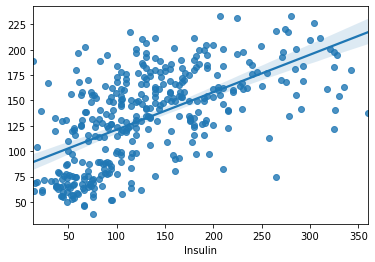

In [ ]:
# regplotㅇ,로 결과값을 비교
# 1에 가까워야 (기울기가 1) 이여야 정확하게 일치
# 지금은 어느정도 경향은 맞는것 처럼 보인다 
# 이상치를 제거해 주면 더 좋은 결과를 보일것 같다

# RandomSearchCV로 찾은 좋은 모델로 예측했더니 기울기가 1에 상당히 가까워졌다

sns.regplot(x=y_train, y=y_predict)

In [ ]:
# r2_score로 결과값을 비교
# 실제 값의 분산 대비 예측값의 분산 비율
from sklearn.metrics import r2_score

r2_score(y_train, y_predict)
# 1에 가까워야 잘 예측한것

0.3511182077623203

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


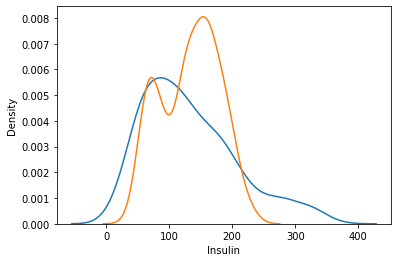

In [ ]:
# distplot으로 예측 분포값을 구한다
# label을 그릴때는 hist를 False로 주어야지 label이 나온다

sns.distplot(y_train, label='y_train', hist=False)
sns.distplot(y_predict, hist=False, label='y_predict')

## 오차구하기

44.50950540080739


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


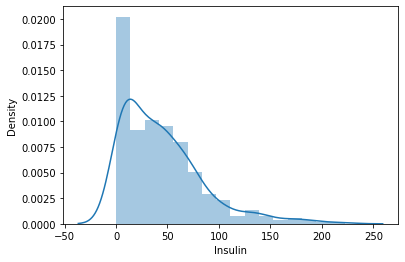

In [ ]:
# MAE
# 절대값사용
# EDA하기 전 86 -> 77
# randomSearchCV -> 44

error = abs(y_train - y_predict)
print(error.mean())

sns.distplot(error)

error값이 얼추 맞지만 300이 넘어가는 큰 값들 도 존재한다

In [ ]:
error.describe()

count    370.000000
mean      44.509505
std       39.928339
min        0.034578
25%       12.339732
50%       37.769185
75%       63.449104
max      222.349230
Name: Insulin, dtype: float64

In [ ]:
# RMSE
# 제곱을 사용
# 126 -> 114
# RandomSearchCV -> 59
np.sqrt(((y_train - y_predict) ** 2).mean())

59.75834240533134

[Text(567.2230571248189, 1062.490909090909, 'Glucose <= 121.5\nmse = 10860.99\nsamples = 390\nvalue = 149.785'),
 Text(210.6263400223358, 1013.0727272727273, 'Glucose <= 90.5\nmse = 3093.914\nsamples = 209\nvalue = 99.464'),
 Text(63.41725692208629, 963.6545454545455, 'BMI <= 28.45\nmse = 596.779\nsamples = 59\nvalue = 59.034'),
 Text(24.432710882163555, 914.2363636363636, 'DiabetesPedigreeFunction <= 0.218\nmse = 537.773\nsamples = 19\nvalue = 48.263'),
 Text(11.497746297488732, 864.8181818181819, 'SkinThickness <= 27.5\nmse = 196.0\nsamples = 2\nvalue = 80.0'),
 Text(8.623309723116549, 815.4000000000001, 'mse = 0.0\nsamples = 1\nvalue = 94.0'),
 Text(14.372182871860915, 815.4000000000001, 'mse = 0.0\nsamples = 1\nvalue = 66.0'),
 Text(37.36767546683838, 864.8181818181819, 'SkinThickness <= 18.5\nmse = 445.543\nsamples = 17\nvalue = 44.529'),
 Text(20.12105602060528, 815.4000000000001, 'DiabetesPedigreeFunction <= 0.294\nmse = 449.69\nsamples = 10\nvalue = 53.9'),
 Text(8.623309723116

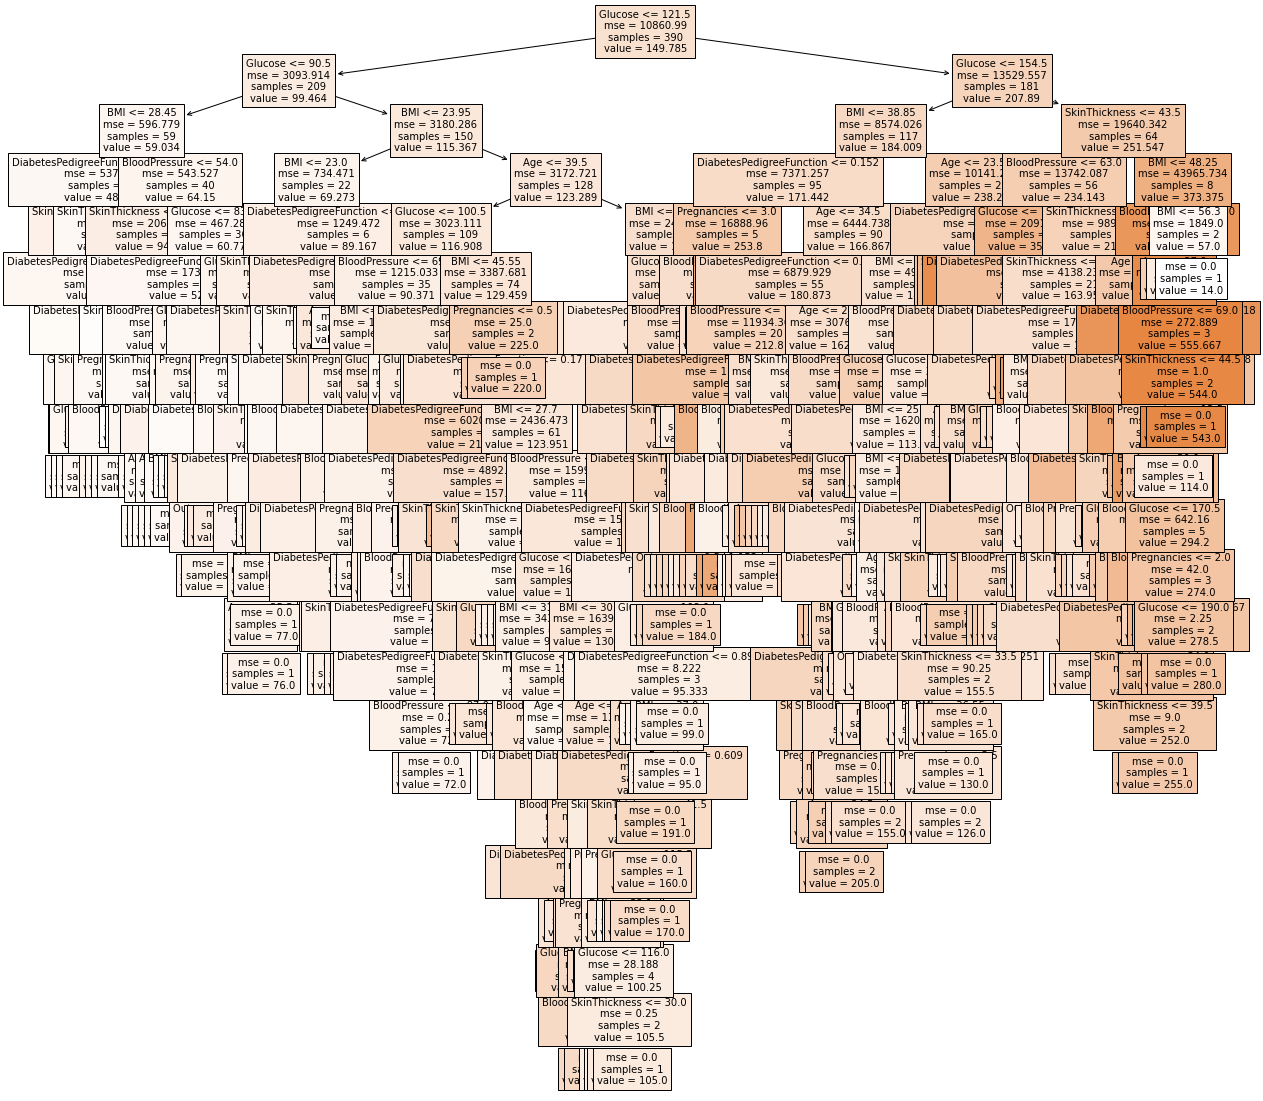

In [ ]:
# plot_tree로 시각화 하기
# cross_validation이여서 꽤 오래걸린다

from sklearn.tree import plot_tree
plt.figure(figsize=(20,20))
plot_tree(model,
          feature_names = feature_names,
          filled=True,
          fontsize=10)

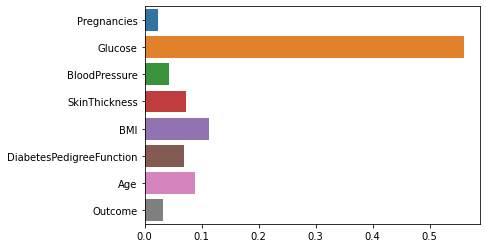

In [ ]:
# 인슐린을 예측하는데 중요한 피쳐

sns.barplot(x=best_estimator.feature_importances_, y= feature_names)

## 인슐린을 예측하도록 학습시킨 모델로 인슐린 예측

In [ ]:
y_test = best_estimator.predict(X_test)
y_test

array([193.45838742,  57.00073016, 184.32789906, 148.18305903,
       167.28434761, 171.21827446, 165.67892282, 194.36736845,
       203.32395549, 126.34789219, 150.36807874, 136.32938198,
       207.43965142, 121.62241674, 195.0225449 , 152.84351012,
       155.46743516,  93.75067775, 117.9768032 , 163.0987181 ,
       150.40436992,  89.8504805 , 184.83635873, 107.28851358,
       173.35458651, 188.45099891, 194.02174919,  53.70165866,
       138.29547868, 135.85355507,  54.62921446, 204.5133043 ,
        69.02174078, 161.28324828,  67.85551502, 161.35384324,
        81.66409248, 140.54402709, 172.91295951, 179.3763975 ,
        54.66441708,  52.46279003,  72.48142049,  93.34270468,
       192.43691757, 112.39565652, 104.22781502,  65.93452286,
       110.45876933, 189.45904337, 149.67553425, 114.63853778,
        63.96280835, 195.72682126,  87.07071892, 203.85561969,
       176.30713384, 152.36620376,  91.91257909,  94.38080105,
        70.78874139, 233.54603407, 162.44441118,  75.66

In [ ]:
train.groupby('Outcome')['Insulin'].describe()

,count,mean,std,min,25%,50%,75%,max
Outcome,,,,,,,,
0,254.0,115.917323,69.844697,15.0,64.25,100.0,151.00,342.0
1,116.0,169.163793,70.789454,14.0,124.25,160.0,207.75,360.0


In [ ]:
test['Insulin'] = y_test

In [ ]:
test.groupby('Outcome')['Insulin'].describe()

,count,mean,std,min,25%,50%,75%,max
Outcome,,,,,,,,
0,236.0,129.196062,43.986820,52.462790,86.988266,137.181805,165.786137,228.384141
1,138.0,172.448194,29.432287,81.574693,157.106132,175.177739,193.118089,236.841722


tran과 비슷한 양상을 보이고 있다

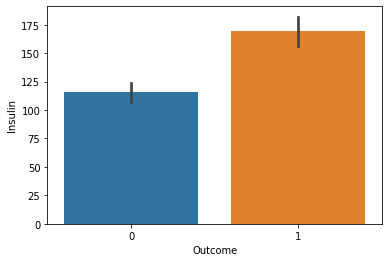

In [ ]:
# Outcome 값에 따른 Insulin의 평균값
sns.barplot(data=train, x='Outcome' , y= 'Insulin')

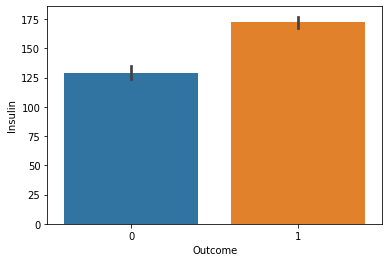

In [ ]:
# 예측값에 대해서 Outcome 값에 따른 Insulin의 평균값
sns.barplot(data=test, x= 'Outcome', y='Insulin')

## Insuline 예측값 데이터에 반영

In [ ]:
df.loc[df['Insulin'] == 0 , 'Insulin']

0      0
1      0
2      0
5      0
7      0
      ..
761    0
762    0
764    0
766    0
767    0
Name: Insulin, Length: 374, dtype: int64

In [ ]:
test['Insulin']

0      193.458387
1       57.000730
2      184.327899
5      148.183059
7      167.284348
          ...    
761    194.919956
762     70.900528
764    156.561675
766    163.904935
767     82.969261
Name: Insulin, Length: 374, dtype: float64

In [ ]:
df.loc[df['Insulin'] == 0 , 'Insulin'] = test['Insulin']
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,193.458387,33.6,0.627,50,1
1,1,85,66,29,57.000730,26.6,0.351,31,0
2,8,183,64,0,184.327899,23.3,0.672,32,1
3,1,89,66,23,94.000000,28.1,0.167,21,0
4,0,137,40,35,168.000000,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180.000000,32.9,0.171,63,0
764,2,122,70,27,156.561675,36.8,0.340,27,0
765,5,121,72,23,112.000000,26.2,0.245,30,0
766,1,126,60,0,163.904935,30.1,0.349,47,1


## 저장

In [ ]:
df.to_csv('diabetes_fill_insulin.csv', index=False)

In [ ]:
pd.read_csv('/content/diabetes_fill_insulin.csv')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,193.458387,33.6,0.627,50,1
1,1,85,66,29,57.000730,26.6,0.351,31,0
2,8,183,64,0,184.327899,23.3,0.672,32,1
3,1,89,66,23,94.000000,28.1,0.167,21,0
4,0,137,40,35,168.000000,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180.000000,32.9,0.171,63,0
764,2,122,70,27,156.561675,36.8,0.340,27,0
765,5,121,72,23,112.000000,26.2,0.245,30,0
766,1,126,60,0,163.904935,30.1,0.349,47,1
